In [1]:
# Step 0. Load libraries and custom functions
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Visualizations -------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics -----------------------------------------------------------
from scipy.stats import chi2_contingency
# Data pre-processing --------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import (ColumnTransformer, make_column_selector)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
# Machine Learning -----------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
# Display pipelines ----------------------------------------------------
from sklearn import set_config
set_config(display='diagram')

In [2]:
# Step 1. Load data and prepare
# This data was extracted from the census bureau database found at
# http://www.census.gov/ftp/pub/DES/www/welcome.html
# Donor: Ronny Kohavi and Barry Becker,
#        Data Mining and Visualization
#        Silicon Graphics.
#
#         e-mail: ronnyk@sgi.com for questions.
# Extraction was done by Barry Becker from the 1994 Census database.  A set of
#   reasonably clean records was extracted using the following conditions:
#   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
#
# Prediction task is to determine whether a person makes over 50K
# a year.
# Variables
# age: continuous.
# workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, 
# Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: Bachelors, Some-college, 11th, HS-grad, Prof-school, 
# Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, 
# Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: Married-civ-spouse, Divorced, Never-married, 
# Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: Tech-support, Craft-repair, Other-service, Sales, 
# Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, 
# Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, 
# Protective-serv, Armed-Forces.
# relationship: Wife, Own-child, Husband, Not-in-family, 
# Other-relative, Unmarried.
# race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: United-States, Cambodia, England, Puerto-Rico, 
# Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, 
# South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, 
# Jamaica, Vietnam, Mexico, Portugal, Ireland, France, 
# Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, 
# Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, 
# Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
# Get the data of names file with the following snipet
# url_headers: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
# f = requests.get(url_headers)
# print(f.text)

url_base = 'https://archive.ics.uci.edu/ml/machine-learning-databases/' 
url_dir = 'adult/adult.data'
url_data = url_base + url_dir
df_raw = pd.read_csv(url_data, header=None)
df_raw.columns = ['age','workclass','fnlwgt','education',\
    'education_num','marital_status','occupation','relationship',\
        'race','sex','capital_gain','capital_loss','hours_per_week',\
            'native_country','income']

In [3]:
# 1.1 Get basic info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
# 1.2 Get a sample
df_raw.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
14363,23,?,55492,Assoc-voc,11,Never-married,?,Not-in-family,Amer-Indian-Eskimo,Female,0,0,30,United-States,<=50K
8017,33,Private,180551,Some-college,10,Separated,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
6228,24,Private,336088,HS-grad,9,Divorced,Exec-managerial,Not-in-family,Amer-Indian-Eskimo,Female,0,0,50,United-States,<=50K
21397,42,Federal-gov,294431,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
20666,38,Private,156728,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,56,United-States,<=50K
18626,35,Private,189382,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
8902,35,Private,228190,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,40,United-States,<=50K
30353,43,Private,48193,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<=50K
9417,33,Private,206051,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
22184,34,Local-gov,51543,Some-college,10,Never-married,Other-service,Not-in-family,White,Male,0,0,48,United-States,<=50K


In [5]:
# 1.3 Transform the data so values are consistent
df_interim = df_raw.copy()
df_interim = df_interim.drop(['education_num'], axis=1)
df_interim['workclass'] = df_interim['workclass'].str.strip()
df_interim['occupation'] = df_interim['occupation'].str.strip()
df_interim = df_interim.replace(['?'],'Unknown')
df_interim['workclass'] = df_interim['workclass'].astype('category')
df_interim['education'] = df_interim['education'].astype('category')
df_interim['marital_status'] = df_interim['marital_status'].astype('category')
df_interim['occupation'] = df_interim['occupation'].astype('category')
df_interim['relationship'] = df_interim['relationship'].astype('category')
df_interim['race'] = df_interim['race'].astype('category')
df_interim['sex'] = df_interim['sex'].astype('category')
df_interim['native_country'] = df_interim['native_country'].astype('category')
df_interim['income'] = df_interim['income'].astype('category')

In [6]:
# 2. Exploratory Data Analysis
# 2.1 Divide the dataset into a train and test sets, to proceed EDA
df = df_interim.copy()
X = df.drop(['income'], axis=1)
y = df[['income']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
df_train = pd.concat([X_train,y_train], axis=1)

In [7]:
# 2.2 Describe the numeric covariates
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.523096,13.627782,17.0,28.0,37.0,47.00,90.0
fnlwgt,24420.0,189499.904505,105535.310093,12285.0,117683.0,178007.5,236804.25,1484705.0
capital_gain,24420.0,1098.912899,7578.972370,0.0,0.0,0.0,0.00,99999.0
capital_loss,24420.0,85.767240,400.194111,0.0,0.0,0.0,0.00,4356.0
hours_per_week,24420.0,40.420229,12.360538,1.0,40.0,40.0,45.00,99.0


In [8]:
# 2.3 Describe the categorical covariates
df_train.describe(include='category')

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
count,24420,24420,24420,24420,24420,24420,24420,24420,24420
unique,9,16,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,16977,7852,11241,3125,9868,20840,16295,21864,18539


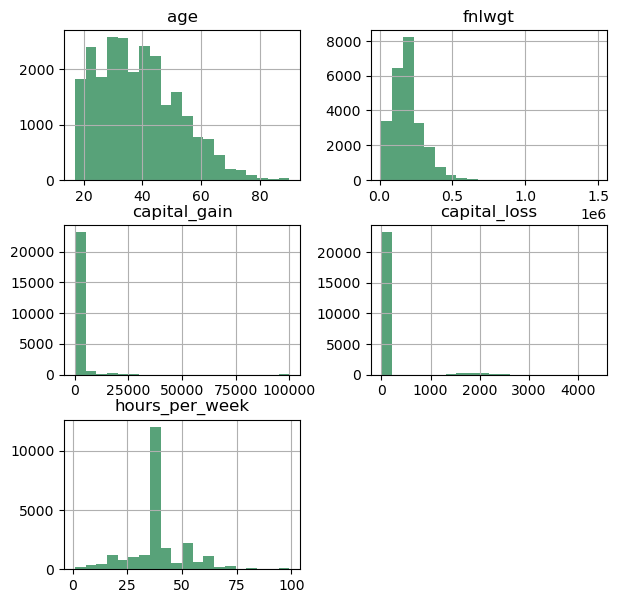

In [9]:
# 2.4 Visualize the histograms for each numerical covariate
df_train.hist(figsize=(7,7), color='seagreen', alpha=0.8, bins=20)
plt.show()

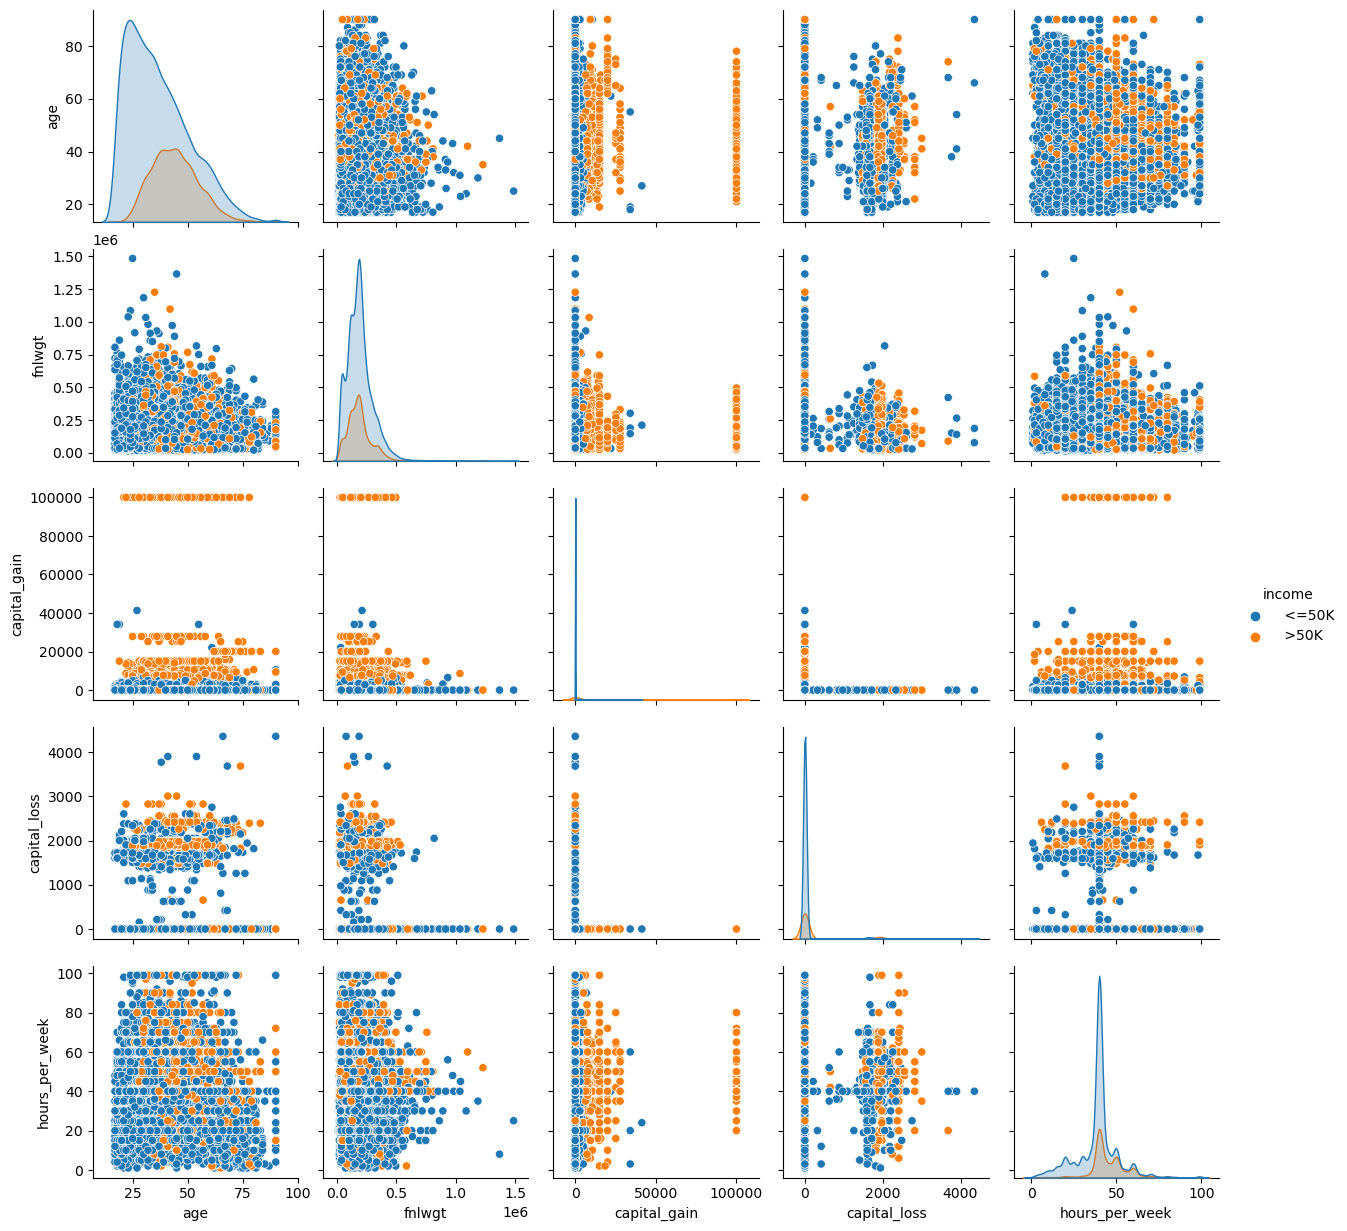

In [10]:
# 2.5 Visualize the bivariate plots
sns.pairplot(data=df_train, hue='income')
plt.show()

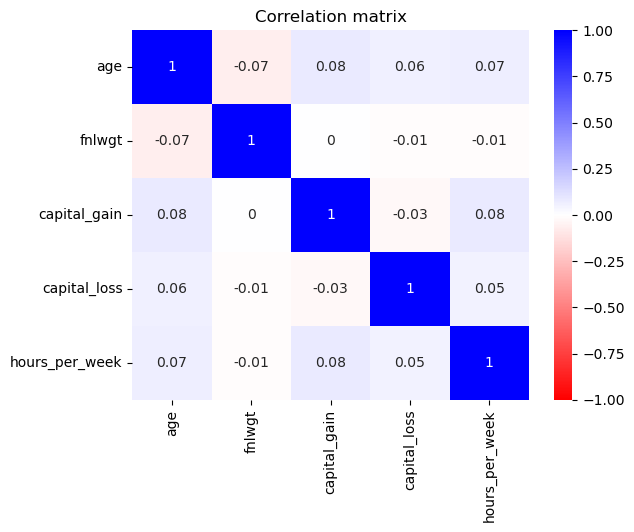

In [11]:
# 2.6 Generate the correlation plot
sns.heatmap(data=df_train.corr(numeric_only=True).round(2), annot=True, vmax=1, vmin=-1, cmap='bwr_r')
plt.title('Correlation matrix')
plt.show()

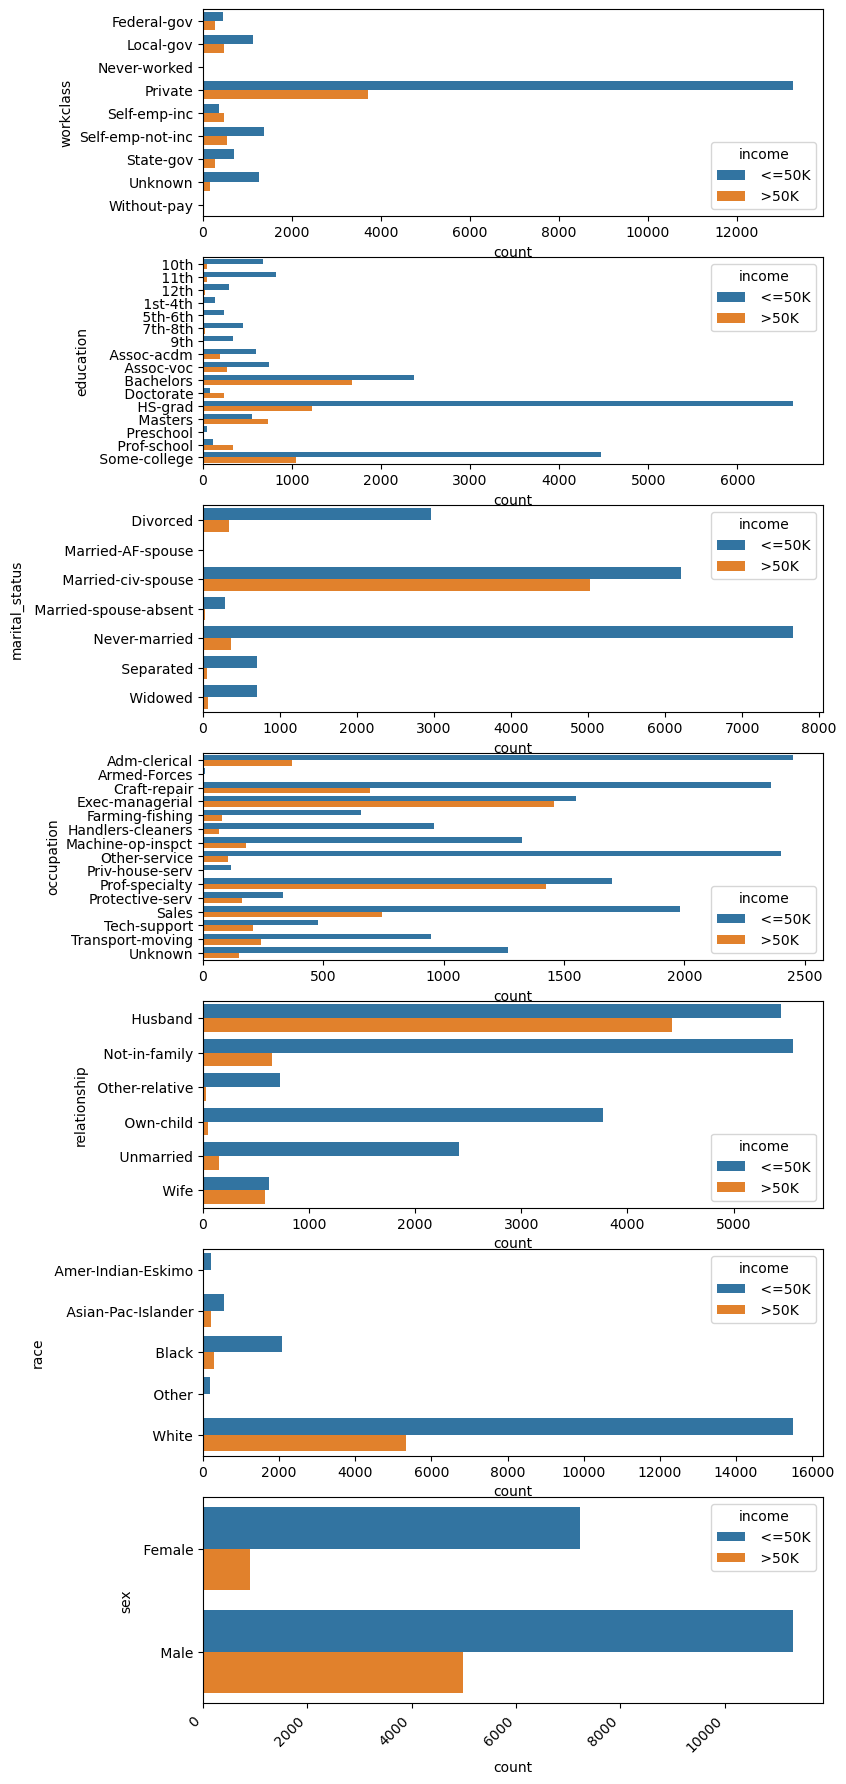

In [12]:
# 2.7 Visualize countplots of categorical covariates
fig, ((a),(b),(c),(d),(e),(f),(g)) = plt.subplots(7,1, figsize=(8,22))
plt.xticks(rotation=45, ha='right')
sns.countplot(data=df_train, y='workclass', hue='income', ax=a)
sns.countplot(data=df_train, y='education', hue='income', ax=b)
sns.countplot(data=df_train, y='marital_status', hue='income', ax=c)
sns.countplot(data=df_train, y='occupation', hue='income', ax=d)
sns.countplot(data=df_train, y='relationship', hue='income', ax=e)
sns.countplot(data=df_train, y='race', hue='income', ax=f)
sns.countplot(data=df_train, y='sex', hue='income', ax=g)
plt.show()

In [13]:
# Calculate correlation between categorical covariates
table = pd.crosstab(df_train['marital_status'], df_train['relationship']).reset_index(drop=True)
X2 = chi2_contingency(table, correction=False)[0]
n = np.sum(table).sum()
min_dim = min(table.shape)-1
cramer_v = np.sqrt((X2/n)/min_dim)
print(f'{cramer_v:.3}')

0.487


In [14]:
# 3.2 Create the pipeline and the hyperparameters for tuning
# Model to apply: Random forest
ppl_rf = Pipeline([
    # Step 1. Scale numeric covariates and encode categorical covariates
    ('cleaning', ColumnTransformer([
        ('num', make_pipeline(MinMaxScaler()), 
        make_column_selector(dtype_exclude='category')),
        ('cat', make_pipeline(OneHotEncoder(drop='first',handle_unknown='ignore')), 
        make_column_selector(dtype_include='category'))
    ])),
    # Step 2. Apply ML algorithm
    ('rforest', RandomForestClassifier(random_state=123, class_weight='balanced'))
])

In [15]:
# 3.3 Fit the base model and get the metrics
ppl_rf.fit(X_train, y_train['income'])
y_hat = ppl_rf.predict(X_test)

/Users/alexismena/miniconda3/envs/basic-machine-learning/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
print(f'Accuracy_score: {accuracy_score(y_test, y_hat):.3f}')

Accuracy_score: 0.857


In [17]:
# 3.6 Fit a better model by tuning the hyperparameters
h_params = [{
    'rforest__min_samples_split':[2,3,4,5,6,7,8],
    'rforest__n_estimators':[1,10,50,75,100,125,250,500,750,1000]
}]
cv_rf = GridSearchCV(ppl_rf, h_params)
cv_rf.fit(X_train, y_train['income'])
y_hat = cv_rf.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_hat):.2f}')

/Users/alexismena/miniconda3/envs/basic-machine-learning/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy score: 0.86


In [18]:
cv_rf.best_params_

{'rforest__min_samples_split': 2, 'rforest__n_estimators': 250}

In [22]:
df_better = df_interim.copy()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: relationship, dtype: int64

In [25]:
df_better['capital_gain'] = df_better['capital_gain'].apply(lambda x: 0 if x==0 else 1)
df_better['capital_loss'] = df_better['capital_loss'].apply(lambda x: 0 if x==0 else 1)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'capital_gain'}>,
        <Axes: title={'center': 'capital_loss'}>],
       [<Axes: title={'center': 'hours_per_week'}>, <Axes: >]],
      dtype=object)

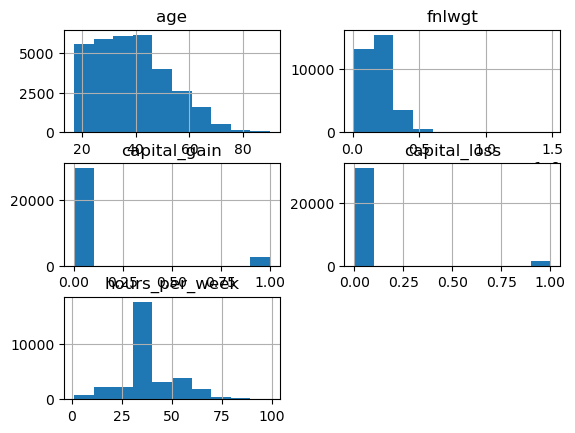

In [26]:
df_better.hist()